# How to Build a Text-Video Retrieval Engine

This notebook illustrates how to build a text-video retrieval engine from scratch using [Milvus](https://milvus.io/) and [Towhee](https://towhee.io/).


**What is Text-Video Retrieval?**

In simple words, text-video retrieval is: given a text query and a pool of candidate videos, select the video which corresponds to the text query.


**What are Milvus & Towhee?**

- Milvus is the most advanced open-source vector database built for AI applications and supports nearest neighbor embedding search across tens of millions of entries.
- Towhee is a framework that provides ETL for unstructured data using SoTA machine learning models.

We'll go through video retrieval procedures and evaluate the performance. Moreover, we managed to make the core functionality as simple as few lines of code, with which you can start hacking your own video retrieval engine.



## Preparation

### Install packages

Make sure you have installed required python packages:

| package |
| -- |
| pymilvus |
| towhee |
| towhee.models |
| pillow |
| ipython |
| gradio |

In [1]:
! python -m pip install -q pymilvus towhee towhee.models pillow ipython gradio

### Prepare the data

First, we need to prepare the dataset and Milvus environment.   

[MSR-VTT (Microsoft Research Video to Text)](https://www.microsoft.com/en-us/research/publication/msr-vtt-a-large-video-description-dataset-for-bridging-video-and-language/) is a dataset for the open domain video captioning, which consists of 10,000 video clips.  

Download the MSR-VTT-1kA test set from [google drive](https://drive.google.com/file/d/1cuFpHiK3jV9cZDKcuGienxTg1YQeDs-w/view?usp=sharing) and unzip it, which contains just 1k videos.  
And the video captions text sentence information is in ./MSRVTT_JSFUSION_test.csv.

The data is organized as follows:
- **test_1k_compress:** 1k compressed test videos in MSR-VTT-1kA.
- **MSRVTT_JSFUSION_test.csv:** a csv file containing an ***key,vid_key,video_id,sentence***, for each video and caption text.

Let's take a quick look

In [2]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/text_video_search.zip -O
! unzip -q -o text_video_search.zip

In [3]:
import pandas as pd
import os

raw_video_path = './test_1k_compress' # 1k test video path.
test_csv_path = './MSRVTT_JSFUSION_test.csv' # 1k video caption csv.

test_sample_csv_path = './MSRVTT_JSFUSION_test_sample.csv'

sample_num = 1000 # you can change this sample_num to be smaller, so that this notebook will be faster.
test_df = pd.read_csv(test_csv_path)
print('length of all test set is {}'.format(len(test_df)))
sample_df = test_df.sample(sample_num, random_state=42)

sample_df['video_path'] = sample_df.apply(lambda x:os.path.join(raw_video_path, x['video_id']) + '.mp4', axis=1)

sample_df.to_csv(test_sample_csv_path)
print('random sample {} examples'.format(sample_num))

df = pd.read_csv(test_sample_csv_path)

df[['video_id', 'video_path', 'sentence']].head()

length of all test set is 1000
random sample 1000 examples


,video_id,video_path,sentence
0,video7579,./test_1k_compress/video7579.mp4,a girl wearing red top and black trouser is pu...
1,video7725,./test_1k_compress/video7725.mp4,young people sit around the edges of a room cl...
2,video9258,./test_1k_compress/video9258.mp4,a person is using a phone
3,video7365,./test_1k_compress/video7365.mp4,cartoon people are eating at a restaurant
4,video8068,./test_1k_compress/video8068.mp4,a woman on a couch talks to a a man


Define some helper function to convert video to gif so that we can have a look at these video-text pairs.   

In [4]:
from IPython import display
from pathlib import Path
import towhee
from PIL import Image

def display_gif(video_path_list, text_list):
    html = ''
    for video_path, text in zip(video_path_list, text_list):
        html_line = '<img src="{}"> {} <br/>'.format(video_path, text)
        html += html_line
    return display.HTML(html)

    
def convert_video2gif(video_path, output_gif_path, num_samples=16):
    frames = (
        towhee.glob(video_path)
              .video_decode.ffmpeg(sample_type='uniform_temporal_subsample', args={'num_samples': num_samples})
              .to_list()[0]
    )
    imgs = [Image.fromarray(frame) for frame in frames]
    imgs[0].save(fp=output_gif_path, format='GIF', append_images=imgs[1:], save_all=True, loop=0)


def display_gifs_from_video(video_path_list, text_list, tmpdirname = './tmp_gifs'):
    Path(tmpdirname).mkdir(exist_ok=True)
    gif_path_list = []
    for video_path in video_path_list:
        video_name = str(Path(video_path).name).split('.')[0]
        gif_path = Path(tmpdirname) / (video_name + '.gif')
        convert_video2gif(video_path, gif_path)
        gif_path_list.append(gif_path)
    return display_gif(gif_path_list, text_list)

Take a look at the ground-truth video-text pairs.

In [5]:
# sample_show_df = sample_df.sample(5, random_state=42)
sample_show_df = sample_df[:5]
video_path_list = sample_show_df['video_path'].to_list()
text_list = sample_show_df['sentence'].to_list()
tmpdirname = './tmp_gifs'
display_gifs_from_video(video_path_list, text_list, tmpdirname=tmpdirname)

### Create a Milvus Collection

Before getting started, please make sure you have [installed milvus](https://milvus.io/docs/v2.0.x/install_standalone-docker.md). Let's first create a `video retrieval` collection that uses the [L2 distance metric](https://milvus.io/docs/v2.0.x/metric.md#Euclidean-distance-L2) and an [IVF_FLAT index](https://milvus.io/docs/v2.0.x/index.md#IVF_FLAT).

In [6]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

connections.connect(host='127.0.0.1', port='19530')

def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='video retrieval')
    collection = Collection(name=collection_name, schema=schema)

    # create IVF_FLAT index for collection.
    index_params = {
        'metric_type':'L2', #IP
        'index_type':"IVF_FLAT",
        'params':{"nlist":2048}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

In [7]:
collection = create_milvus_collection('text_video_retrieval', 512)

## Text-Video retrieval

In this section, we'll show how to build our text-video retrieval engine using Milvus. The basic idea behind text-video retrieval is the extract embeddings from videos using a Transformer network and store them in Milvus, then using another Transformer network to get text embeddings and compare with those stored in Milvus.

We use [Towhee](https://towhee.io/), a machine learning framework that allows for creating data processing pipelines. [Towhee](https://towhee.io/) also provides predefined operators which implement insert and query operation in Milvus.


### Load Video Embeddings into Milvus

We first extract embeddings from images with `CLIP4Clip` model and insert the embeddings into Milvus for indexing. Towhee provides a [method-chaining style API](https://towhee.readthedocs.io/en/main/index.html) so that users can assemble a data processing pipeline with operators.   

[CLIP4Clip](https://arxiv.org/abs/2104.08860) is a video-text retrieval model based on [CLIP (ViT-B)](https://github.com/openai/CLIP). The [towhee clip4clip operator](https://towhee.io/video-text-embedding/clip4clip) with pretrained weights can easily extract video embedding and text embedding by a few codes.

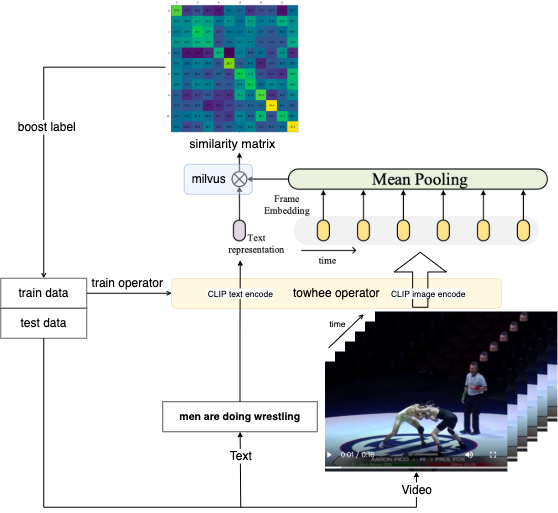

Before you start running the clip4clip operator, you should make sure you have make [git](https://git-scm.com/) and [git-lfs](https://git-lfs.github.com/) installed.    

For git(If you have installed, just skip it):
```
sudo apt-get install git
```
For git-lfs(You must install it for downloading checkpoint weights on backend):
```
sudo apt-get install git-lfs
git lfs install
```


In [8]:
%%time
import os
import towhee

device = 'cuda:2'
# device = 'cpu'

# For the first time you run this line, 
# it will take some time 
# because towhee will download operator with weights on backend.
dc = (
    towhee.read_csv(test_sample_csv_path).unstream()
      .runas_op['video_id', 'id'](func=lambda x: int(x[-4:]))
      .video_decode.ffmpeg['video_path', 'frames'](sample_type='uniform_temporal_subsample', args={'num_samples': 12}) \
      .runas_op['frames', 'frames'](func=lambda x: [y for y in x]) \
      .video_text_embedding.clip4clip['frames', 'vec'](model_name='clip_vit_b32', modality='video', device=device) \
      .to_milvus['id', 'vec'](collection=collection, batch=30)
)

CPU times: user 1h 14min 30s, sys: 1min 55s, total: 1h 16min 25s
Wall time: 1min 19s


In [9]:
print('Total number of inserted data is {}.'.format(collection.num_entities))
dc.select['video_id', 'id', 'vec']().show()

Total number of inserted data is 1000.


video_id,id,vec
video7579,7579,"[-0.046955414, -0.012318517, 0.05594952, ...] shape=(512,)"
video7725,7725,"[0.057752915, 0.026032623, -0.017264651, ...] shape=(512,)"
video9258,9258,"[-0.01112327, 0.054949787, -0.033538133, ...] shape=(512,)"
video7365,7365,"[-0.0137340445, -0.0064378446, -0.02168003, ...] shape=(512,)"
video8068,8068,"[0.023609513, -0.033269204, 0.0024328423, ...] shape=(512,)"


Here is detailed explanation for each line of the code:

- `towhee.read_csv(test_sample_csv_path)`: read tabular data from csv file;

- `.runas_op['video_id', 'id'](func=lambda x: int(x[-4:]))`: for each row from the data, convert the data type of the column `id` from last 4 number of `video_id`;

- `.video_decode.ffmpeg` and `runas_op`: subsample the video uniformly, and then get a list of images in the video, which are the input of the clip4clip model;

- `.video_text_embedding.clip4clip['frames', 'vec'](model_name='clip_vit_b32', modality='video')`: extract embedding feature from the images subsampled from video, and then mean pool them in the temporal dimension, which repre.

- `.to_milvus['id', 'vec'](collection=collection, batch=30)`: insert video embedding features in to Milvus;


In [10]:
%%time
dc = (
    towhee.read_csv(test_sample_csv_path).unstream()
      .video_text_embedding.clip4clip['sentence','text_vec'](model_name='clip_vit_b32', modality='text', device=device)
      .milvus_search['text_vec', 'top10_raw_res'](collection=collection, limit=10)
      .runas_op['video_id', 'ground_truth'](func=lambda x : [int(x[-4:])])
      .runas_op['top10_raw_res', 'top1'](func=lambda res: [x.id for i, x in enumerate(res) if i < 1])
      .runas_op['top10_raw_res', 'top5'](func=lambda res: [x.id for i, x in enumerate(res) if i < 5])
      .runas_op['top10_raw_res', 'top10'](func=lambda res: [x.id for i, x in enumerate(res) if i < 10])
)

CPU times: user 1h 47min 32s, sys: 2min 37s, total: 1h 50min 10s
Wall time: 2min 2s


## Evaluation

We have finished the core functionality of the text-video retrieval engine. However, we don't know whether it achieves a reasonable performance. We need to evaluate the retrieval engine against the ground truth so that we know if there is any room to improve it.

In this section, we'll evaluate the strength of our text-video retrieval using recall@topk:   
`Recall@topk` is the proportion of relevant items found in the top-k recommendations. Suppose that we computed recall at 10 and found it is 40% in our top-10 recommendation system. This means that 40% of the total number of the relevant items appear in the top-k results.

In [11]:
dc.select['video_id', 'sentence', 'ground_truth', 'top10_raw_res', 'top1', 'top5', 'top10']().show()
# dc.show()

video_id,sentence,ground_truth,top10_raw_res,top1,top5,top10
video7579,a girl wearing red top and black...,[7579] len=1,"[{""id"": 7579, ""score"": 1.4152562618255615},{""id"": 9969, ""score"": 1.479762315750122},{""id"": 8837, ""score"": 1.4900273084640503},{""id"": 9347, ""score"": 1.4925360679626465},...] len=10",[7579] len=1,"[7579,9969,8837,9347,...] len=5","[7579,9969,8837,9347,...] len=10"
video7725,young people sit around the edge...,[7725] len=1,"[{""id"": 7725, ""score"": 1.3606964349746704},{""id"": 8014, ""score"": 1.490865707397461},{""id"": 8339, ""score"": 1.4913759231567383},{""id"": 8442, ""score"": 1.503324270248413},...] len=10",[7725] len=1,"[7725,8014,8339,8442,...] len=5","[7725,8014,8339,8442,...] len=10"
video9258,a person is using a phone,[9258] len=1,"[{""id"": 9258, ""score"": 1.401209831237793},{""id"": 9257, ""score"": 1.4216816425323486},{""id"": 9697, ""score"": 1.4404691457748413},{""id"": 7910, ""score"": 1.4957969188690186},...] len=10",[9258] len=1,"[9258,9257,9697,7910,...] len=5","[9258,9257,9697,7910,...] len=10"
video7365,cartoon people are eating at a r...,[7365] len=1,"[{""id"": 7365, ""score"": 1.4048435688018799},{""id"": 8781, ""score"": 1.4607740640640259},{""id"": 9537, ""score"": 1.4721850156784058},{""id"": 7831, ""score"": 1.5039441585540771},...] len=10",[7365] len=1,"[7365,8781,9537,7831,...] len=5","[7365,8781,9537,7831,...] len=10"
video8068,a woman on a couch talks to a a ...,[8068] len=1,"[{""id"": 7162, ""score"": 1.4739655256271362},{""id"": 8304, ""score"": 1.4785505533218384},{""id"": 8068, ""score"": 1.4936964511871338},{""id"": 7724, ""score"": 1.495842456817627},...] len=10",[7162] len=1,"[7162,8304,8068,7724,...] len=5","[7162,8304,8068,7724,...] len=10"


In [12]:
benchmark = (
    dc.with_metrics(['mean_hit_ratio',]) \
        .evaluate['ground_truth', 'top1'](name='recall_at_1') \
        .evaluate['ground_truth', 'top5'](name='recall_at_5') \
        .evaluate['ground_truth', 'top10'](name='recall_at_10') \
        .report()
)

,mean_hit_ratio
recall_at_1,0.421
recall_at_5,0.712
recall_at_10,0.813


This result is almost identical to the recall metrics represented in the paper. You can find more detail about metrics in [paperwithcode](https://paperswithcode.com/paper/clip4clip-an-empirical-study-of-clip-for-end/review/?hl=30331).

## Release a Showcase

We've learnt how to build a reverse video search engine. Now it's time to add some interface and release a showcase. Towhee provides `towhee.api()` to wrap the data processing pipeline as a function with `.as_function()`. So we can build a quick demo with this `milvus_search_function` with [Gradio](https://gradio.app/).

In [14]:
import gradio

show_num = 3
with towhee.api() as api:
    milvus_search_function = (
         api.video_text_embedding.clip4clip(model_name='clip_vit_b32', modality='text', device=device)
            .milvus_search(collection=collection, limit=show_num)
            .runas_op(func=lambda res: [os.path.join(raw_video_path, 'video' + str(x.id) + '.mp4') for x in res])
            .as_function()
    )

interface = gradio.Interface(milvus_search_function, 
                             inputs=[gradio.Textbox()],
                             outputs=[gradio.Video(format='mp4') for _ in range(show_num)]
                            )

interface.launch(inline=True, share=True)

Running on local URL:  http://127.0.0.1:7861/
Running on public URL: https://29428.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7fd3c7033550>,
 'http://127.0.0.1:7861/',
 'https://29428.gradio.app')

In [ ]:
# import shutil
# shutil.rmtree(tmpdirname)